Extract the metrics of importance 

e.g. temperature, time, lat, lon, etc..

In [11]:
from kelp_metrics import main as extract_metrics

kelp_data = extract_metrics(lower_lat=27, upper_lat=37)

100%|██████████| 3514/3514 [00:05<00:00, 622.88it/s]

Data/kelp_metrics_27_37.pkl saved
dict_keys(['dkelp', 'dkelp_kelp', 'dtemp', 'dtemp_temp', 'dtemp_temp_lag', 'dtemp_temp_lag2', 'kelp', 'temp', 'temp_lag', 'temp_lag2', 'sunlight', 'time', 'dtime', 'lat', 'lon', 'dlat', 'dlon', 'temp_char', 'average_temp', 'slope_dkelp_temp_char', 'slope_dkelp_temp_char_err'])


In [12]:
kelp_data

{'dkelp': array([108.71428571,  12.78571429,  32.        , ..., -39.26666667,
         18.31111111, -50.82222222]),
 'dkelp_kelp': array([82.07142857, 17.67857143, 21.78571429, ..., 32.72222222,
        42.71111111, 26.45555556]),
 'dtemp': array([ 6.7769596 ,  5.76474651, -4.0387045 , ..., -1.694416  ,
         2.27213469, -3.26796671]),
 'dtemp_temp': array([291.02050389, 293.02785648, 291.25238932, ..., 287.73642058,
        288.20997256, 287.71205655]),
 'dtemp_temp_lag': array([289.58661994, 289.43206554, 293.69951585, ..., 287.83245337,
        286.09302105, 288.20997256]),
 'dtemp_temp_lag2': array([292.1595135 , 290.49330125, 291.46816738, ..., 286.5642871 ,
        286.00067473, 286.09302105]),
 'kelp': array([ 73.42857143,  27.71428571, 136.42857143, ...,  33.55555556,
         51.86666667,   1.04444444]),
 'temp': array([292.39818118, 287.63202409, 294.40898369, ..., 287.07390521,
        289.3460399 , 286.0780732 ]),
 'temp_lag': array([         nan, 291.54121579, 287.63202

## Clean the data and format arrays

In [13]:
import numpy as np

features = {
    # name : variable
    'Temperature [C]': kelp_data['temp'] - 273.15,
    '1Q Lag Temperature [C]': kelp_data['temp_lag'] - 273.15,
    '2Q Lag Temperature [C]': kelp_data['temp_lag2'] - 273.15,
    'Longitude [deg]': kelp_data['lon'], 
    'Latitude [deg]': kelp_data['lat'],
    #'Elevation [m]': kelp_data['elevation'],
    'Sunlight [day]': kelp_data['sunlight']
    #'time': kelp_data['time'],
}

# make arrays
X = np.array([features[k] for k in features]).T
y = kelp_data['kelp']
t = kelp_data['time']
lat = kelp_data['lat']
lon = kelp_data['lon']

# Remove nans from lagged values
nanmask = np.isnan(features['1Q Lag Temperature [C]']) | np.isnan(features['2Q Lag Temperature [C]'])
X = X[~nanmask]
y = y[~nanmask]
t = t[~nanmask]
lat = lat[~nanmask]
lon = lon[~nanmask]

## Save data to disk

In [14]:
import pandas as pd
import numpy as np

feat_df = {}
for i, k in enumerate(features):
    feat_df[k] = X[:,i]

feat_df['time'] = t
feat_df['kelp'] = y

# Convert the data to a pandas DataFrame and ensure 'time' is in datetime format
df = pd.DataFrame(feat_df)

# Save data to disk using pandas to_csv function with column names as the first row
df.to_csv('extracted_kelp_27_37.csv', index=False)

## Split data into training/validation sets

In [15]:
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

print(f"Shape of all the data: {X.shape}")

# Split data into training and testing sets (e.g., 80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Shape of training: {X_train.shape}")
print(f"Shape of testing: {X_test.shape}")

Shape of all the data: (70239, 6)
Shape of training: (56191, 6)
Shape of testing: (14048, 6)


## Fit a regression model using linear least-squares

In [16]:
# Fit OLS regressor on training data
res = sm.OLS(y_train, sm.add_constant(X_train)).fit()

# Predict on training data and compute the average absolute error
y_ols_train = res.predict(sm.add_constant(X_train))
abs_err_ols_train = np.abs(y_train - y_ols_train).mean()
print(f"Avg. Absolute Error Train: {abs_err_ols_train:.3f} m^2")

# Predict on testing data and compute the average absolute error
y_ols_test = res.predict(sm.add_constant(X_test))
abs_err_ols_test = np.abs(y_test - y_ols_test).mean()
print(f"Avg. Absolute Error Test: {abs_err_ols_test:.3f} m^2")

# Regression coefficients
print("Coefficients:")
for feat, coef in zip(features.keys(), res.params[1:]):  # Exclude the constant term
    print(f"  {feat:<25} : {coef:.3f}")

print(res.summary())

Avg. Absolute Error Train: 58.165 m^2
Avg. Absolute Error Test: 57.972 m^2
Coefficients:
  Temperature [C]           : -0.633
  1Q Lag Temperature [C]    : -6.874
  2Q Lag Temperature [C]    : -2.319
  Longitude [deg]           : -4.876
  Latitude [deg]            : -12.052
  Sunlight [day]            : 167.303
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.090
Model:                            OLS   Adj. R-squared:                  0.089
Method:                 Least Squares   F-statistic:                     920.9
Date:                Tue, 03 Sep 2024   Prob (F-statistic):               0.00
Time:                        20:34:58   Log-Likelihood:            -3.3056e+05
No. Observations:               56191   AIC:                         6.611e+05
Df Residuals:                   56184   BIC:                         6.612e+05
Df Model:                           6                  

In [17]:
res.params

array([-48.14457884,  -0.63348526,  -6.87415609,  -2.31939668,
        -4.87604667, -12.05209889, 167.30281315])

## analyze correlation metrics for each feature

In [18]:
from sklearn.feature_selection import mutual_info_regression
from scipy import stats
import json

def correlation_tests(x, y, input_name, output_name):
    # measure the significance of the correlation
    correlations = {'input': input_name, 'output':output_name}

    # Pearson's correlation
    corr, pval = stats.pearsonr(x, y)
    correlations['pearsonr'] = {'corr': round(corr, 3), 'pval': round(pval, 3)}

    # Kendall's tau
    tau, pval = stats.kendalltau(x, y)
    correlations['kendalltau'] = {'tau': round(tau, 3), 'pval': round(pval, 3)}

    # Calculate the Spearman rank correlation
    corr, pval = stats.spearmanr(x, y)
    correlations['spearmanr'] = {'corr': round(corr, 3), 'pval': round(pval, 3)}

    # Mann-Kendall
    tau, pval = stats.mstats.kendalltau(x, y)
    correlations['mann.kendall'] = {'tau': round(tau, 3), 'pval': round(pval, 3)}

    # Mutual Information (Regression)
    mi = mutual_info_regression(x.reshape(-1, 1), y)
    correlations['mutual_info_regression'] = {'mi': round(mi[0], 3)}
    
    return correlations

# for each feature examine the correlations
for i, feat in enumerate(features):
    corr = correlation_tests(X[:,i],y, feat, 'Kelp Area [m^2]')
    print(json.dumps(corr,indent=4))

{
    "input": "Temperature [C]",
    "output": "Kelp Area [m^2]",
    "pearsonr": {
        "corr": 0.023,
        "pval": 0.0
    },
    "kendalltau": {
        "tau": 0.006,
        "pval": 0.011
    },
    "spearmanr": {
        "corr": 0.01,
        "pval": 0.01
    },
    "mann.kendall": {
        "tau": 0.006,
        "pval": 0.011
    },
    "mutual_info_regression": {
        "mi": 0.02
    }
}
{
    "input": "1Q Lag Temperature [C]",
    "output": "Kelp Area [m^2]",
    "pearsonr": {
        "corr": -0.2,
        "pval": 0.0
    },
    "kendalltau": {
        "tau": -0.133,
        "pval": 0.0
    },
    "spearmanr": {
        "corr": -0.198,
        "pval": 0.0
    },
    "mann.kendall": {
        "tau": -0.133,
        "pval": 0.0
    },
    "mutual_info_regression": {
        "mi": 0.043
    }
}
{
    "input": "2Q Lag Temperature [C]",
    "output": "Kelp Area [m^2]",
    "pearsonr": {
        "corr": -0.068,
        "pval": 0.0
    },
    "kendalltau": {
        "tau": -0

Saved map_2003-02-15.png


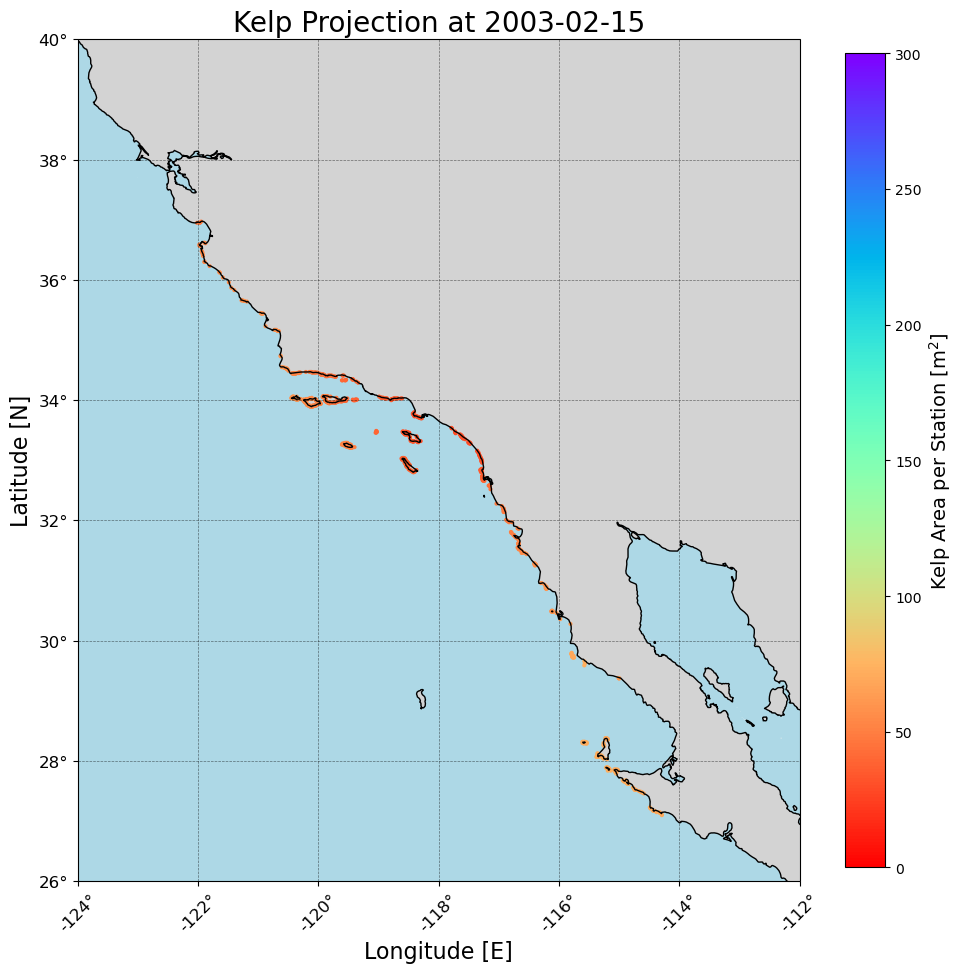

In [24]:
import cartopy.feature
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from tqdm import tqdm

# create a map
utime = np.unique(t)

# extract data at first time point
mask = t == utime[0]
Xm = X[mask]
ym = y[mask]
latm = lat[mask]
lonm = lon[mask]

# predict
ym_ols = res.predict(sm.add_constant(Xm))

# set up the figure
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

# draw the map
ax.coastlines()
ax.set_global()
# set title with datetime
datestr = str(utime[0]).split('T')[0]
ax.set_title(f"Kelp Projection at {datestr}", fontsize=20)
ax.add_feature(cartopy.feature.LAND, facecolor='lightgray')
ax.add_feature(cartopy.feature.OCEAN, facecolor='lightblue')

# plot test and lat/lon
# 4/5 index of X is lat/lon
im = ax.scatter(lonm, latm, c=ym_ols, marker='.', label="Kelp Prediction", transform=ccrs.PlateCarree(), cmap='rainbow_r',vmin=0,vmax=300, s=15)
cbar = plt.colorbar(im, ax=ax, shrink=0.9)
cbar.set_label('Kelp Area per Station [m$^2$]', fontsize=14)

# add labels on axes every 10 degrees
ax.set_xticks(np.arange(-180, 180, 2), crs=ccrs.PlateCarree())
ax.set_xticklabels([f'{x}°' for x in np.arange(-180, 180, 2)], fontsize=12, rotation=45)
ax.set_yticks(np.arange(-90, 90, 2), crs=ccrs.PlateCarree())
ax.set_yticklabels([f'{x}°' for x in np.arange(-90, 90, 2)], fontsize=12)

ax.set_xlabel(f'Longitude [E]', fontsize=16)
ax.set_ylabel(f'Latitude [N]', fontsize=16)
ax.grid(True,color='k', alpha=0.5, linestyle='--', linewidth=0.5)

# zoom in on the bounding box
ax.set_extent([-124, -112, 26, 40], crs=ccrs.PlateCarree())

plt.tight_layout()
file_name = f'map_{datestr}.png'
plt.savefig(file_name)
print(f"Saved {file_name}")
plt.show()